In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

os.environ['CLMM_MODELING_BACKEND'] = 'nc' # here you may choose ccl, nc (NumCosmo) or ct (cluster_toolkit)

import clmm
from clmm import Cosmology
import scipy.integrate as integrate

In [2]:
cosmo = Cosmology(H0=70.0, Omega_dm0=0.3-0.045, Omega_b0=0.045, Omega_k0=0.0)

In [3]:
moo = clmm.Modeling(massdef='mean', delta_mdef=200, halo_profile_model='einasto')

moo.set_cosmo(cosmo)
moo.set_concentration(5)
moo.set_mass(1.e14)

z_cl = 0.1

In [98]:
def R_centered(theta, R, Roff):
    return np.sqrt(R*R + Roff*Roff - 2*R*Roff*np.cos(theta))

def integrand1(theta, R, Roff):
    return moo.eval_surface_density(R_centered(theta, R, Roff), z_cl)/(2*np.pi)

# exact
def Sigma_mis_exact(R, Roff):    
    return integrate.quad_vec(integrand1, 0., 2*np.pi, args=(R, Roff))[0]

def integrand_Sigmamean_exact(Rprime, Roff):    
    return Rprime * Sigma_mis_exact(Rprime, Roff)


In [114]:
import scipy
def Sigma_mean_mis_trap(R_arr, Roff, regrid=100):
    # use finer grid that R_arr to evaluate integral, for precision purpose. Controld by the regrid_level parameter. 
    # If regrid_level=1, the original R_arr is used for cumulative_trapezoid. 
    new_R_arr = np.logspace(np.log10(1.e-5), np.log10(R_arr.max()), regrid)
    
    res = (2./new_R_arr**2) * integrate.cumulative_trapezoid(new_R_arr * Sigma_mis_exact(new_R_arr, Roff), new_R_arr, initial=0)
    
    f = scipy.interpolate.interp1d(new_R_arr, res)
    return f(R_arr)

def Sigma_mean_mis_exact(R_arr, Roff):
    res=[]
    for i,R in enumerate(R_arr):
        res.append(integrate.quad(integrand_Sigmamean_exact, 0., R, args=(Roff))[0]*2./R/R)
    return np.array(res)

def DS_mis_approx(R_arr, Roff, regrid=100): 
    return Sigma_mean_mis_trap(R_arr, Roff, regrid=regrid) - Sigma_mis_exact(R_arr, Roff)

def DS_mis_exact(R_arr, Roff): 
    return Sigma_mean_mis_exact(R_arr, Roff) - Sigma_mis_exact(R_arr, Roff)

In [106]:
Roff = 0.2
R_arr = np.logspace(-2,1,50)

In [115]:
Sigma_mis = Sigma_mis_exact(R_arr, Roff)

In [126]:
%%time 
DeltaSigma_mis_exact = DS_mis_exact(R_arr, Roff)

CPU times: user 1min 47s, sys: 222 ms, total: 1min 48s
Wall time: 1min 48s


In [122]:
%%time
DeltaSigma_mis_1e2 = DS_mis_approx(R_arr, Roff, regrid=100)

CPU times: user 149 ms, sys: 2.41 ms, total: 151 ms
Wall time: 151 ms


In [123]:
%%time 
DeltaSigma_mis_1e3 = DS_mis_approx(R_arr, Roff, regrid=1000)

CPU times: user 765 ms, sys: 4.19 ms, total: 769 ms
Wall time: 771 ms


In [124]:
%%time 
DeltaSigma_mis_1e4 = DS_mis_approx(R_arr, Roff, regrid=10000)

CPU times: user 6.92 s, sys: 16.8 ms, total: 6.94 s
Wall time: 6.94 s


In [107]:
Sigma = moo.eval_surface_density(R_arr, z_cl)
DeltaSigma = moo.eval_excess_surface_density(R_arr, z_cl)

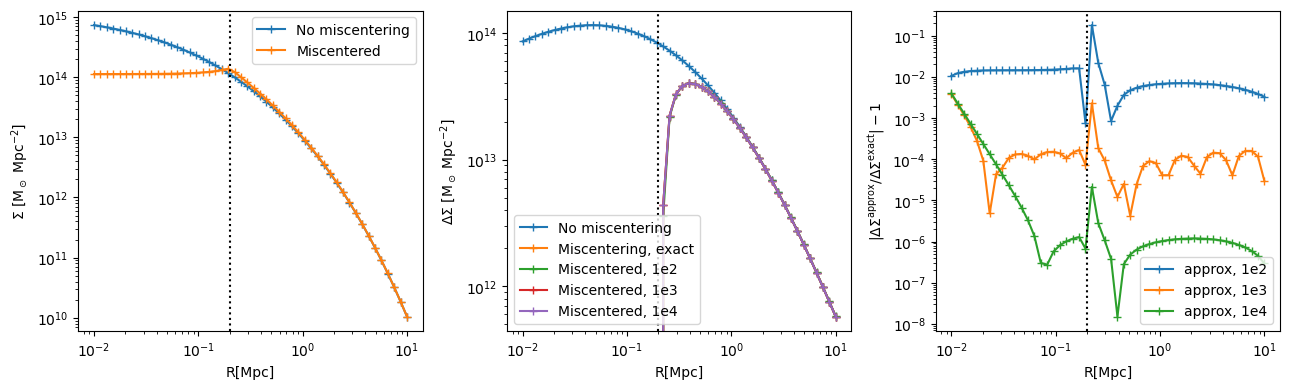

In [120]:
fig, axes = plt.subplots(ncols=3, figsize=(13,4))
axes[0].loglog(R_arr, Sigma, label='No miscentering', marker='+')
axes[0].loglog(R_arr, Sigma_mis, label='Miscentered', marker='+')
axes[0].axvline(Roff, c='k', ls=':')
axes[0].set_xlabel('R[Mpc]')
axes[0].set_ylabel(r'$\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[1].loglog(R_arr, DeltaSigma, label='No miscentering', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_exact, label='Miscentering, exact', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e2, label='Miscentered, 1e2', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e3, label='Miscentered, 1e3', marker='+')
axes[1].loglog(R_arr, DeltaSigma_mis_1e4, label='Miscentered, 1e4', marker='+')
#axes[1].loglog(R_arr, DeltaSigma_mis_1e5, label='Miscentered, 1e5', marker='+')
axes[1].axvline(Roff, c='k', ls=':')
axes[1].legend()
axes[1].set_xlabel('R[Mpc]')
axes[1].set_ylabel(r'$\Delta\Sigma$ [M$_\odot$ Mpc$^{-2}$]')

axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e2/DeltaSigma_mis_exact)-1), marker='+', label='approx, 1e2')
axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e3/DeltaSigma_mis_exact)-1), marker='+', label='approx, 1e3')
axes[2].loglog(R_arr, np.abs((DeltaSigma_mis_1e4/DeltaSigma_mis_exact)-1), marker='+', label='approx, 1e4')
axes[2].axvline(Roff, c='k', ls=':')
axes[2].set_xlabel('R[Mpc]')
axes[2].set_ylabel(r'$|\Delta\Sigma^{\rm approx}/\Delta\Sigma^{\rm exact}|-1$')


axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()